In [1]:
!pip install d2l==1.0.0-alpha0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 1.1 MB/s 


## 15.6 Fine-Tuning BERT for Sequence-Level and Token-Level Applications

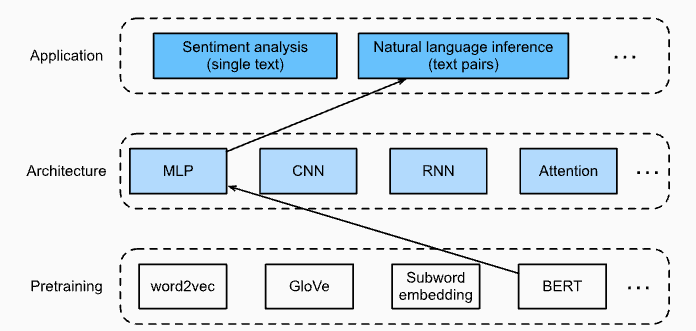

- 앞의 절에서 BERT model의 pretraining, fine tunning 등에 대해서 진행했지만, 사실 BERT 모델의 파라미터는 110 milion ~ 340 milion으로 엄청난 computing power가 요구되기에 적용해보기 쉽지않음. 
- 그렇기에 이번 절에서는 1) sequence level 과 2) token level에서 NLP를 적용해보는 과정을 진행함. 
- Sequence level: sequence level에서는 classification이나 regression 같은 문제에서 어떻게 BERT model 형태의 text input값을 output label로 변환하는지에 대해서 살펴볼 예정 
- Token level: text tagging, questin answering과 같은 방법들을 적용하는 것을 소개, BERT model이 어떻게 input을 나타내고 output label형태로 변환되는지에 대해서 살펴볼 예정 
- **전체적으로 어떠한 work flow로 진행이 되는지에 대해서 소개함 **


### 15.6.1. Single Text Classification 



- **Single text classification**은 input값으로 '**single text sequence**'를 받고 output으로 classification 결과를 도출함 
-  **cls** 는 sequence classification에 사용되며 전체 input text sequence에 대한 정보를 encoding 해주는 역할을 함 
- **sep** 는 single text의 끝을 표시해주는 역할로서 여러 데이터가 들어올 경우 텍스트를 한쌍 한쌍으로 분리해주기 위한 역할을 함 
- 결국 들어온 정보들에 대해서 연결된 dense layer로 연결되어서 output distribution결과를 도출해내는 과정으로 진행됨 
- google: 하나의 문장을 넣고, 긍정이냐 부정이냐 중립이냐를 분류하는 문제에 사용됨 

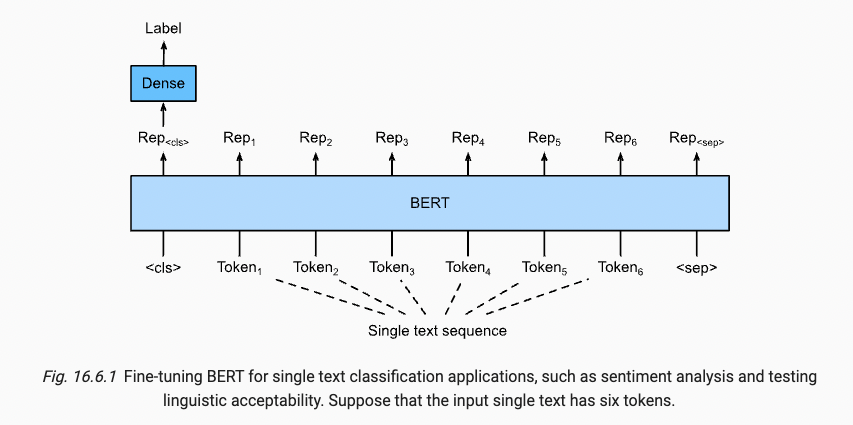

### 15.6.2 Text Pair Classification or Regression 

- Text pair classification은 **'semantic textual similarity'** 를 판별하기 위한 목적의 NLP 
- Semantic textual similarity란 서로 다른 두 문장이 얼마나 유사한지를 평가하기 위한 목적
- Similiarity score를 설정해서 각 두 문장이 서로 얼마나 유사한지 0점이면 전혀 유사하지 않은 것, 5점이면 두 문장이 서로 유사하다라는 것을 보여줌 

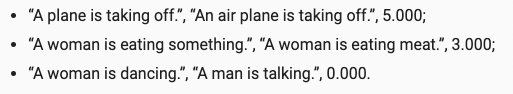


- 모델의 구조를 살펴보면 앞전의 single text classification과 마찬가지로 cls, sep이 있는 것을 확인 가능한데, input data에 대해서 sep을 통해서 분리하여 두쌍의 문장간에 유사도를 확인함 

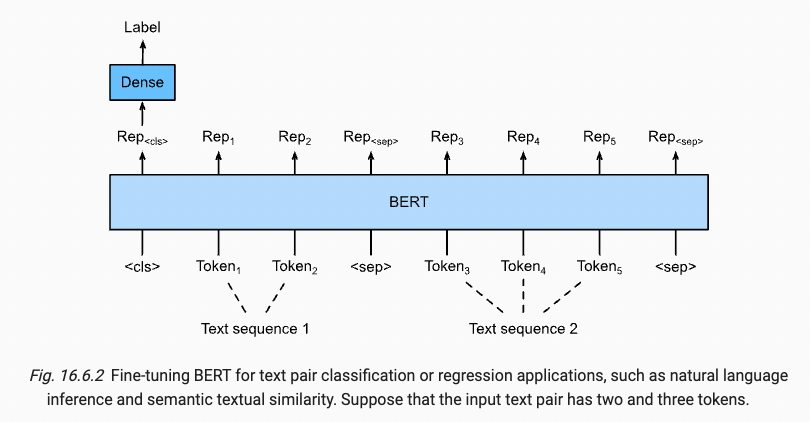

### 15.6.3 Text Tagging 

- **'Part of speech tagging'** 은 문장 내 단어들의 품사를 식별하여 태그를 붙여주는 것을 의미 - 튜플 형태 (단어, 태그)

- ex) John Smith's car is new 
 -> 

 John (NNP (noun, proper singular)), 
 
 Smith's (possessive ending), 

 car (noun, singular or mass),

 is (verb, base form),

 new (adjective)

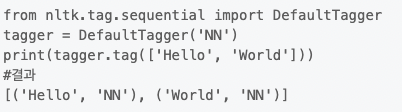

- Single text classification과 유사하지만 다른점은 각각의 token 하나하나에 대해서 label과 연결되어서 출력된다는 차이점이 존재 

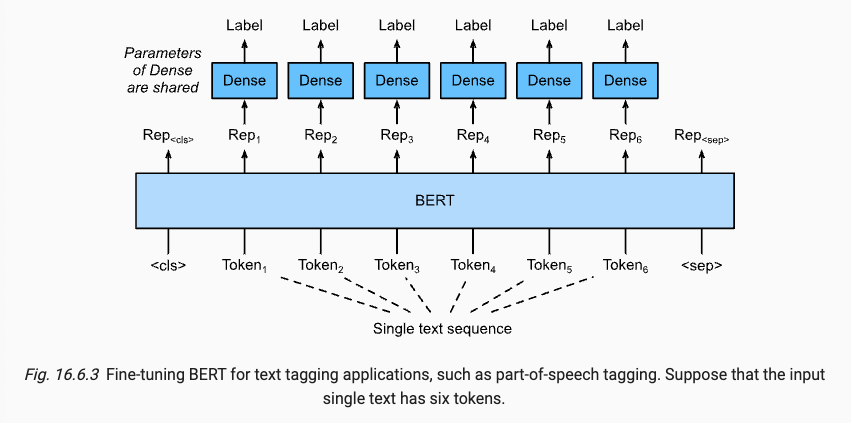

### 16.6.4. Question Answering

Qusestion answering은 extractive question answering (추출형 질의응답)으로 -> 문서에 대해서 질문을 제시하고 문서 자체에 존재하는 텍스트 범위를 행당 질문에 대한 답변으로 추출하는 작업 

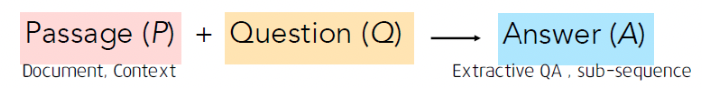

- Question: CLS 토큰부분에 질문의 시작 부분에 대한 input 단어가 토큰에 추가됨 
- Passage: SEP 뒤에 부분에 질문에 대한 답변이 추가됨 
- 책에는 없는 내용이지만 **'Segment Embeddings'** 로 문장 A 또는 B를 나타내는 마커가 각 토큰에 추가되어서 모델이 문장을 구분 가능하도록 도와준다. -> input layer에 제공되기 전에 토큰 임베딩에 추가함 

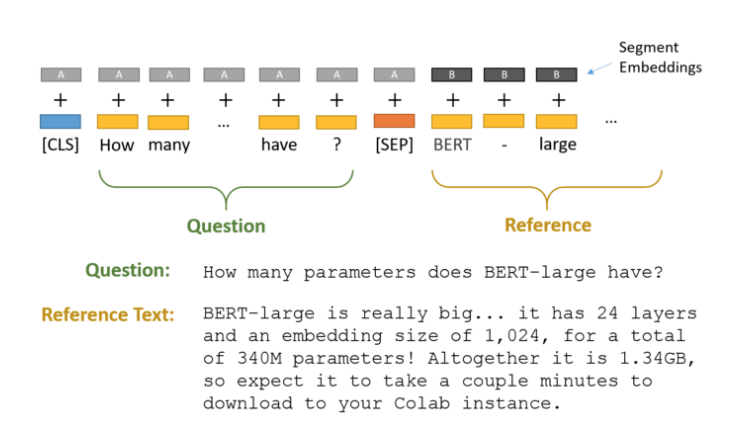

- 텍스트의 모든 토큰들에 대한 최종 임베딩 결과를 start token classifier에 제공 
- Start token classifier에는 모든 단어에 적용되는 단일 가중치 세트만 있음. 
- Output embedding과 Start 'weight'사이의 내적을 취해 모든 단어에 대한 확률 분포를 생성하기 위해 Softmax function을 활용해 확률을 구해줌 
- 시작 토큰이 될 확률이 가장 높은 단어를 선별 

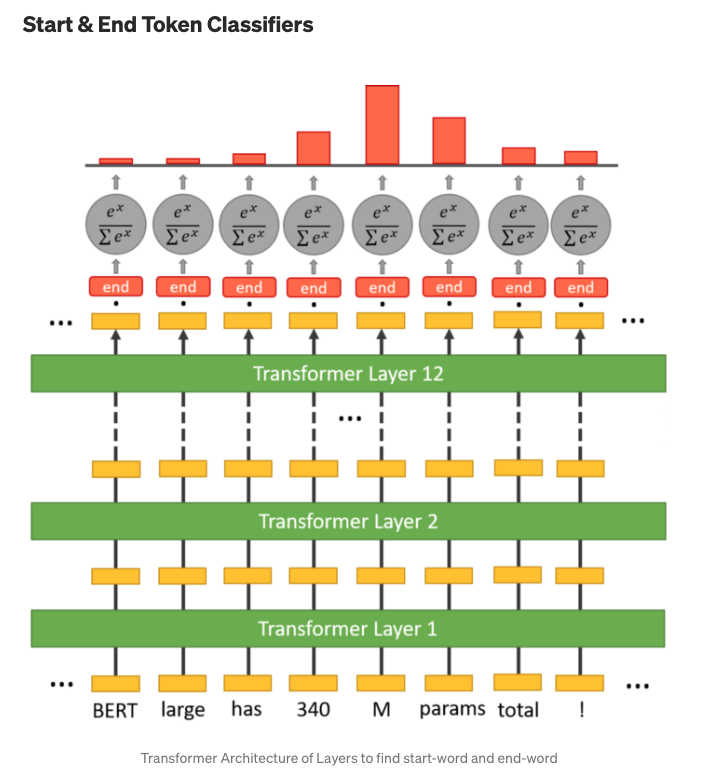

## 16.7 Natural Language Inference: Fine-Tunning BERT

image.png

- In this section, we will download a pretrained small version of BERT, then fine-tune it for natural language inference on the SNLI (Stanford Natural Language Inference) dataset.
- SNLI dataset: sentence-pair간의 entailment 관계를 분류하는 데이터셋으로, sentence1이 sentence2를 포함하는 의미를 가지는지 분류

In [2]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

- 우리는 bert.small model을 기반으로 실습을 진행해볼 예정

### 16.7.1. Loading Pretrained BERT

In [3]:
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [4]:
def load_pretrained_model(pretrained_model, 
                          num_hiddens, 
                          ffn_num_hiddens,
                          num_heads, 
                          num_blks, 
                          dropout, 
                          max_len, 
                          devices):
    # load data 
    data_dir = d2l.download_extract(pretrained_model)

    # get text 
    # 'vocab.josn' files = defines the vocabulary set 
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}

    # get model 
    bert = d2l.BERTModel(
        len(vocab), 
        num_hiddens, 
        ffn_num_hiddens=ffn_num_hiddens, 
        num_heads=4,
        num_blks=2, 
        dropout=0.2, 
        max_len=max_len)
    
    # Load pretrained BERT parameters
    # 'pretrained.params' files = file of the pretrained parameters 
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

우리가 위에 지정해둔 lod_pretrained_model 함수를 통해서 load and fine tune the small version of the pretrained BERT. 

In [5]:
# def try_all_gpus():
#     devices = [torch.device(f'cuda:{i}')
#              for i in range(torch.cuda.device_count())]
#     return devices if devices else [torch.device('cpu')]

device = d2l.try_all_gpus()

bert, vocab = load_pretrained_model(
    'bert.small', 
    num_hiddens=256, 
    ffn_num_hiddens=512, 
    num_heads=4,
    num_blks=2, 
    dropout=0.1, 
    max_len=512, 
    devices=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
bert

BERTModel(
  (encoder): BERTEncoder(
    (token_embedding): Embedding(60005, 256)
    (segment_embedding): Embedding(2, 256)
    (blks): Sequential(
      (0): TransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (attention): DotProductAttention(
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (W_q): LazyLinear(in_features=0, out_features=256, bias=True)
          (W_k): LazyLinear(in_features=0, out_features=256, bias=True)
          (W_v): LazyLinear(in_features=0, out_features=256, bias=True)
          (W_o): LazyLinear(in_features=0, out_features=256, bias=True)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0.2, inplace=False)
          (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): LazyLinear(in_features=0, out_features=512, bias=True)
          (relu): ReLU()
          (dense2): LazyLinear(in_features=0, out_features=256, bias=True)


In [7]:
vocab.token_to_idx

{'<unk>': 0,
 '<pad>': 1,
 '<mask>': 2,
 '<cls>': 3,
 '<sep>': 4,
 'the': 5,
 ',': 6,
 '.': 7,
 'of': 8,
 'in': 9,
 'and': 10,
 '"': 11,
 'a': 12,
 'to': 13,
 'was': 14,
 'is': 15,
 'for': 16,
 'on': 17,
 'as': 18,
 ')': 19,
 '(': 20,
 'with': 21,
 'by': 22,
 'he': 23,
 "'s": 24,
 'that': 25,
 'at': 26,
 'from': 27,
 'his': 28,
 'it': 29,
 'an': 30,
 'were': 31,
 'are': 32,
 'which': 33,
 'this': 34,
 'also': 35,
 'be': 36,
 'had': 37,
 'has': 38,
 'or': 39,
 'first': 40,
 'one': 41,
 'their': 42,
 'after': 43,
 'its': 44,
 'but': 45,
 'new': 46,
 'not': 47,
 'who': 48,
 'her': 49,
 'she': 50,
 'they': 51,
 'two': 52,
 'have': 53,
 'been': 54,
 "'": 55,
 'all': 56,
 'other': 57,
 'when': 58,
 'during': 59,
 'time': 60,
 'there': 61,
 'into': 62,
 'more': 63,
 'school': 64,
 'may': 65,
 'over': 66,
 'years': 67,
 'up': 68,
 'year': 69,
 'only': 70,
 'would': 71,
 'most': 72,
 'where': 73,
 'three': 74,
 'between': 75,
 'later': 76,
 'city': 77,
 'world': 78,
 'some': 79,
 'can': 80,
 'o

In [13]:
vocab.token_to_idx

{'<unk>': 0,
 '<pad>': 1,
 '<mask>': 2,
 '<cls>': 3,
 '<sep>': 4,
 'the': 5,
 ',': 6,
 '.': 7,
 'of': 8,
 'in': 9,
 'and': 10,
 '"': 11,
 'a': 12,
 'to': 13,
 'was': 14,
 'is': 15,
 'for': 16,
 'on': 17,
 'as': 18,
 ')': 19,
 '(': 20,
 'with': 21,
 'by': 22,
 'he': 23,
 "'s": 24,
 'that': 25,
 'at': 26,
 'from': 27,
 'his': 28,
 'it': 29,
 'an': 30,
 'were': 31,
 'are': 32,
 'which': 33,
 'this': 34,
 'also': 35,
 'be': 36,
 'had': 37,
 'has': 38,
 'or': 39,
 'first': 40,
 'one': 41,
 'their': 42,
 'after': 43,
 'its': 44,
 'but': 45,
 'new': 46,
 'not': 47,
 'who': 48,
 'her': 49,
 'she': 50,
 'they': 51,
 'two': 52,
 'have': 53,
 'been': 54,
 "'": 55,
 'all': 56,
 'other': 57,
 'when': 58,
 'during': 59,
 'time': 60,
 'there': 61,
 'into': 62,
 'more': 63,
 'school': 64,
 'may': 65,
 'over': 66,
 'years': 67,
 'up': 68,
 'year': 69,
 'only': 70,
 'would': 71,
 'most': 72,
 'where': 73,
 'three': 74,
 'between': 75,
 'later': 76,
 'city': 77,
 'world': 78,
 'some': 79,
 'can': 80,
 'o

### 16.7.2. The Dataset for Fine-Tuning BERT

- For the downstream task natural language inference on the SNLI dataset, we define a customized dataset class SNLIBERTDataset.
- The premise and hypothesis form a pair of text sequence and is packed into one BERT input sequence
- We use 4 worker processes to generate training or testing examples in parallel.

In [8]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

After downloading the SNLI dataset, we generate training and testing examples by instantiating the SNLIBERTDataset class. 

In [9]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
BATCH_SIZE, MAX_LEN, NUM_WORKERS = 512, 128, 4
# get loaded dataset 
data_dir = d2l.download_extract('SNLI')

train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), 
                            MAX_LEN, 
                            vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), 
                           MAX_LEN, 
                           vocab)

train_iter = torch.utils.data.DataLoader(train_set, 
                                         BATCH_SIZE, 
                                         shuffle=True,
                                         num_workers=NUM_WORKERS)
test_iter = torch.utils.data.DataLoader(test_set, 
                                        BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 16.7.3. Fine-Tuning BERT 

In [10]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

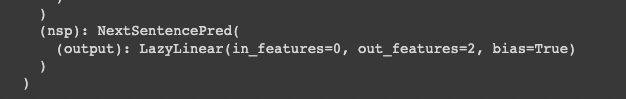

- 마지막 classifier부분에 대해서만 변경을 진행 

  **(output): LazyLinear(in_features=0, out_features=3, bias=True)**

- out features 부분에 대해서만 변경한 것을 확인 가능 

In [11]:
net = BERTClassifier(bert)
net

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


BERTClassifier(
  (encoder): BERTEncoder(
    (token_embedding): Embedding(60005, 256)
    (segment_embedding): Embedding(2, 256)
    (blks): Sequential(
      (0): TransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (attention): DotProductAttention(
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (W_q): LazyLinear(in_features=0, out_features=256, bias=True)
          (W_k): LazyLinear(in_features=0, out_features=256, bias=True)
          (W_v): LazyLinear(in_features=0, out_features=256, bias=True)
          (W_o): LazyLinear(in_features=0, out_features=256, bias=True)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0.2, inplace=False)
          (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): LazyLinear(in_features=0, out_features=512, bias=True)
          (relu): ReLU()
          (dense2): LazyLinear(in_features=0, out_features=256, bias=T

loss 0.522, train acc 0.790, test acc 0.779
2536.6 examples/sec on [device(type='cuda', index=0)]


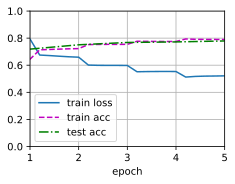

In [12]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, device)